In [1]:
import torch
from torchvision import models, transforms
import torch.optim as optim
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DeepDream:
    def __init__(self, image):
        self.image = image
        self.model = models.vgg16(pretrained=True)
        self.model = self.model.cuda()
        self.modules = list(self.model.features.modules())
        # vgg16 use 224x224 images
        imgSize = 224
        self.transformNormalise = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.transformPreprocess = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            self.transformNormalise
        ])
        self.tensorMean = torch.Tensor([0.485, 0.456, 0.406])
        
        self.tensorMean = self.tensorMean.cuda()
        self.tensorStd = torch.Tensor([0.229, 0.224, 0.225])
        self.tensorStd = self.tensorStd.cuda()
    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

In [3]:
class DeepDream(DeepDream):
    def deepDream(self, image, layer, iterations, lr):
        transformed = self.transformPreprocess(image).unsqueeze(0) 
        transformed = transformed.cuda()
        input = torch.autograd.Variable(transformed, requires_grad=True)
        self.model.zero_grad()
        optimizer = optim.Adam([input.requires_grad_()],lr=0.2)
        for _ in range(iterations):
            optimizer.zero_grad()
            out = input
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = -out.norm() 
            loss.backward()
            optimizer.step()

        input = input.data.squeeze()
        input.transpose_(0,1)
        input.transpose_(1,2)
        input = self.toImage(input)
        input = input.cpu()
        input = np.clip(input, 0, 1)
        return Image.fromarray(np.uint8(input*255))

In [4]:
class DeepDream(DeepDream):
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            # scale down the image
            image_small = image.filter(ImageFilter.GaussianBlur(2)) # 高斯模糊
            small_size = (int(image.size[0]/2), int(image.size[1]/2))
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.Resampling.LANCZOS)
            # run deepDreamRecursive on the scaled down image
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)
        img_result = self.deepDream(image, layer, iterations, lr)
        img_result = img_result.resize(image.size)
        return img_result
    def deepDreamProcess(self,iterations):
        return self.deepDreamRecursive(self.image, 28, iterations, 0.2, 30)

Text(0.5, 1.0, 'Image loaded from ./cat.jpg')

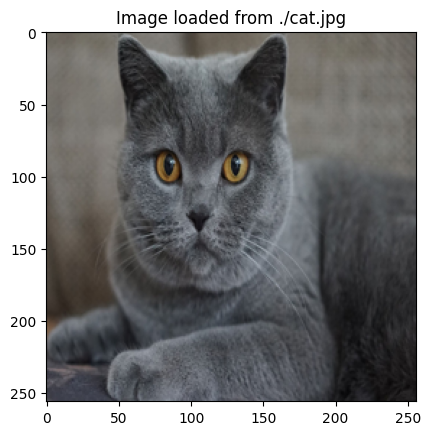

In [5]:
IMAGE_PATH = './cat.jpg'
img = Image.open(IMAGE_PATH)
img = img.resize((256, 256))
pyplot.imshow(img)
pyplot.title("Image loaded from " + IMAGE_PATH)

/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yanai-lab/xiong-p/.conda/envs/cu111/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


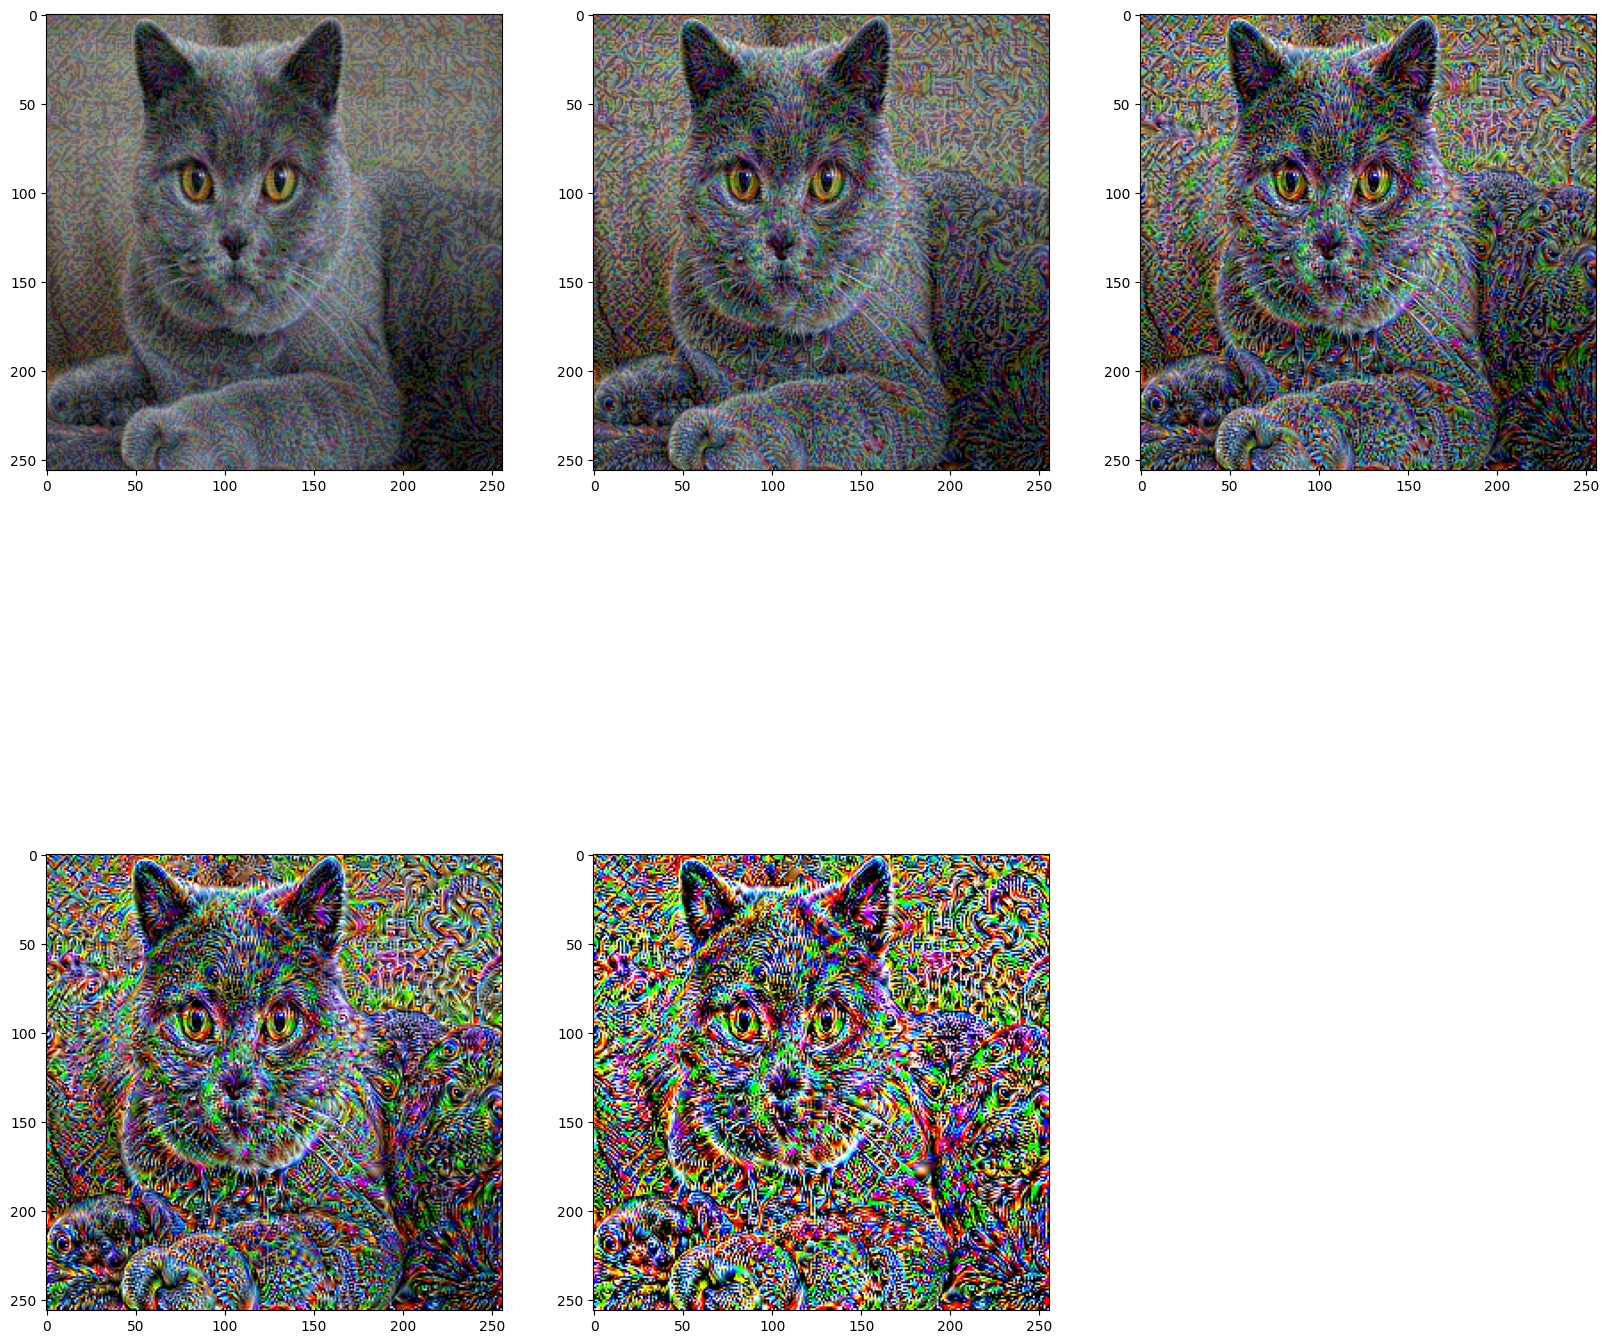

In [6]:
plt.figure(figsize=(20,20))
img_deep_dream1 = DeepDream(img).deepDreamProcess(2)
plt.subplot(231)
plt.imshow(img_deep_dream1)
img_deep_dream2 = DeepDream(img).deepDreamProcess(5)
plt.subplot(232)
plt.imshow(img_deep_dream2)
img_deep_dream3 = DeepDream(img).deepDreamProcess(10)
plt.subplot(233)
plt.imshow(img_deep_dream3)
img_deep_dream4 = DeepDream(img).deepDreamProcess(20)
plt.subplot(234)
plt.imshow(img_deep_dream4)
img_deep_dream5 = DeepDream(img).deepDreamProcess(50)
plt.subplot(235)
plt.imshow(img_deep_dream5)
plt.show()
